In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES']='2'

import keras 
from keras.layers.merge import Grad
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger


Using TensorFlow backend.


In [2]:
#load the data 
import h5py 
import numpy as np 
data_prefix="/srv/scratch/annashch/deeplearning/gradient_exp/"
train_hdf5=h5py.File(data_prefix+"train_data.hdf5",'r')
train_X=train_hdf5['X']['sequence']
train_Y=train_hdf5['Y']['output']

valid_hdf5=h5py.File(data_prefix+'valid_data.hdf5','r')
valid_X=valid_hdf5['X']['sequence']
valid_Y=valid_hdf5['Y']['output']

test_hdf5=h5py.File(data_prefix+"test_data.hdf5",'r')
test_X=test_hdf5['X']['sequence']
test_Y=test_hdf5['Y']['output']

weights_gata=np.load('weights_gata_train.npy')
Y_grads_gata=np.load('gradients_gata_train.npy')
weights_tal=np.load('weights_tal_train.npy')
Y_grads_tal=np.load('gradients_tal_train.npy')
weights_gata_valid=np.load('weights_gata_valid.npy')
Y_grads_gata_valid=np.load('gradients_gata_valid.npy')
weights_tal_valid=np.load('weights_tal_valid.npy')
Y_grads_tal_valid=np.load('gradients_tal_valid.npy')
weights_gata_test=np.load('weights_gata_test.npy')
Y_grads_gata_test=np.load('gradients_gata_test.npy')
weights_tal_test=np.load('weights_tal_test.npy')
Y_grads_tal_test=np.load('gradients_tal_test.npy')

In [167]:
#build the model -- without gradient reward (this is our baseline)
input_shape=(200,4)
pool_size=10 
np.random.seed(1234)
inp = keras.layers.Input(shape=input_shape)
conv1 = keras.layers.Convolution1D(nb_filter=1, filter_length=20, subsample_length=1)(inp)
relu1 = keras.layers.Activation("relu")(conv1)
gap = keras.layers.pooling.GlobalAveragePooling1D()(relu1)
dense = keras.layers.Dense(1)(gap)
grad_layer1 = Grad(task_index=0)([inp, dense])
sigmoid_out = keras.layers.Activation("sigmoid")(dense)
model = keras.models.Model(input=inp, output=sigmoid_out)
model.compile(optimizer="adam", loss="binary_crossentropy",metrics=["binary_accuracy"])

#train the model 
model_output_path="benchmarkModel"
#checkpointer = ModelCheckpoint(filepath=model_output_path)
earlystopper = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
tensorboard = TensorBoard( write_images=True)
csv_logger = CSVLogger('training.benchmark.log')

model.fit(x=np.asarray(train_X), 
          y=np.asarray(train_Y[:,0]),
          callbacks=[earlystopper,csv_logger,tensorboard],
          batch_size=250,
          epochs=10,
          validation_data=tuple([valid_X,valid_Y[:,0]]),
          verbose=1)

/users/avanti/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(strides=1, filters=1, kernel_size=20)`
/users/avanti/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=Tensor("in...)`


Train on 2400 samples, validate on 300 samples
Epoch 1/10
2400/2400 [==============================] - 1s - loss: 0.6954 - binary_accuracy: 0.3629 - val_loss: 0.6927 - val_binary_accuracy: 0.6033
Epoch 2/10
2400/2400 [==============================] - 0s - loss: 0.6915 - binary_accuracy: 0.6542 - val_loss: 0.6904 - val_binary_accuracy: 0.6567
Epoch 3/10
2400/2400 [==============================] - 0s - loss: 0.6895 - binary_accuracy: 0.6629 - val_loss: 0.6887 - val_binary_accuracy: 0.6567
Epoch 4/10
2400/2400 [==============================] - 0s - loss: 0.6879 - binary_accuracy: 0.6629 - val_loss: 0.6873 - val_binary_accuracy: 0.6567
Epoch 5/10
2400/2400 [==============================] - 0s - loss: 0.6864 - binary_accuracy: 0.6629 - val_loss: 0.6859 - val_binary_accuracy: 0.6567
Epoch 6/10
2400/2400 [==============================] - 0s - loss: 0.6849 - binary_accuracy: 0.6629 - val_loss: 0.6845 - val_binary_accuracy: 0.6567
Epoch 7/10
2400/2400 [==============================] - 0s 

/users/avanti/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3025: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


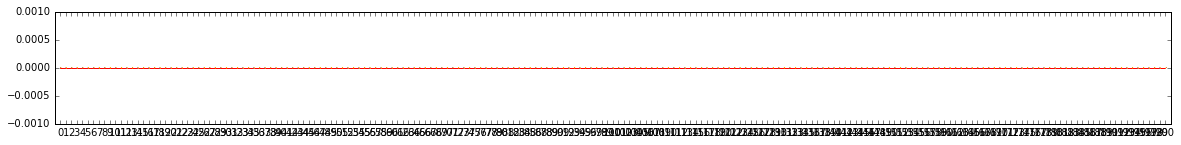

In [168]:
from keras import backend as K
f = K.function([inp], [grad_layer1])
import numpy as np
idx=10
grads, = f([train_X[0:idx]])

from deeplift.visualization import viz_sequence 
%matplotlib inline

viz_sequence.plot_weights(grads[2]-np.mean(grads[2],axis=1)[:,None])


In [199]:
#build the model with gradient reward 
reload(keras.losses)
reload(keras.engine.training)
reload(keras.models)
from keras.layers.merge import Grad
input_shape=(200,4)
pool_size=20 
np.random.seed(1234)
inp = keras.layers.Input(shape=input_shape)
conv1 = keras.layers.Convolution1D(nb_filter=10, filter_length=20, subsample_length=1)(inp)
relu1 = keras.layers.Activation("relu")(conv1)
gap = keras.layers.pooling.GlobalAveragePooling1D()(relu1)
dense = keras.layers.Dense(1)(gap)
sigmoid_out = keras.layers.Activation("sigmoid")(dense)
grad_layer1 = Grad(task_index=0)([inp, dense])
model_grad = keras.models.Model(input=inp, output=[sigmoid_out, grad_layer1])
model_grad.compile(optimizer="adam", 
                   loss=["binary_crossentropy",
                         keras.losses.get_positionwise_cosine_1d(pool_size=pool_size)],
                   metrics=["binary_accuracy"])


#train the model 
model_grad.fit(x=np.asarray(train_X), 
          y=[np.asarray(train_Y)[:,0],Y_grads_gata],
               validation_data=tuple([valid_X,
                                      [np.asarray(valid_Y[:,0]),Y_grads_gata_valid],
                                      
                                     ]),
          batch_size=250,
          epochs=20,
          verbose=1)

/users/avanti/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(strides=1, filters=10, kernel_size=20)`
/users/avanti/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`


Train on 2400 samples, validate on 300 samples
Epoch 1/20
2400/2400 [==============================] - 4s - loss: -0.5131 - activation_173_loss: 0.6925 - grad_95_loss: -1.2056 - activation_173_binary_accuracy: 0.5325 - grad_95_binary_accuracy: 0.9376 - val_loss: -1.8573 - val_activation_173_loss: 0.6893 - val_grad_95_loss: -2.5466 - val_activation_173_binary_accuracy: 0.6500 - val_grad_95_binary_accuracy: 0.9378
Epoch 2/20
2400/2400 [==============================] - 2s - loss: -2.3608 - activation_173_loss: 0.6878 - grad_95_loss: -3.0486 - activation_173_binary_accuracy: 0.6600 - grad_95_binary_accuracy: 0.9376 - val_loss: -2.6543 - val_activation_173_loss: 0.6839 - val_grad_95_loss: -3.3382 - val_activation_173_binary_accuracy: 0.6733 - val_grad_95_binary_accuracy: 0.9378
Epoch 3/20
2400/2400 [==============================] - 1s - loss: -3.0104 - activation_173_loss: 0.6819 - grad_95_loss: -3.6923 - activation_173_binary_accuracy: 0.6700 - grad_95_binary_accuracy: 0.9376 - val_loss:

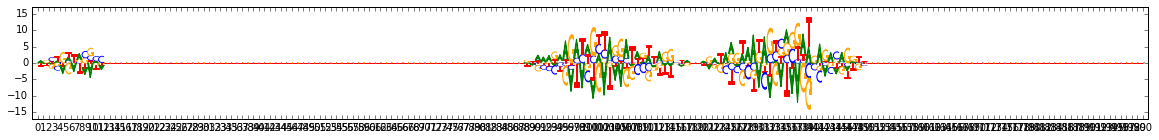

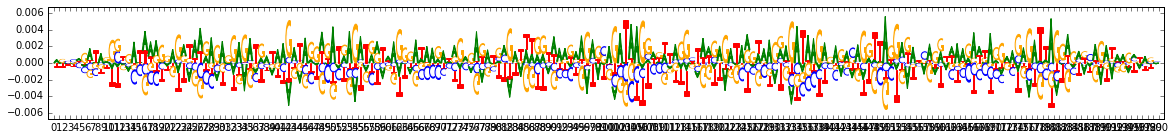

In [200]:
from keras import backend as K
update = K.gradients(model_grad._all_losses[1],grad_layer1)[0]
f = K.function([inp, model_grad.sample_weights[1], model_grad.targets[1]], [update, grad_layer1])
import numpy as np
idx=10
grad_update,grads = f([train_X[0:idx],np.ones((idx)).astype('float32'),Y_grads_gata[0:idx]])

from deeplift.visualization import viz_sequence 
%matplotlib inline

viz_sequence.plot_weights(grad_update[2])
viz_sequence.plot_weights(grads[2]-np.mean(grads[2],axis=1)[:,None])


In [190]:
model_nograd = keras.models.Model(input=inp, output=[sigmoid_out])
model_nograd.compile(optimizer="adam", 
                   loss=["binary_crossentropy"],
                   metrics=["binary_accuracy"])
#train the model 
model_nograd.fit(x=np.asarray(train_X), 
          y=[np.asarray(train_Y)[:,0]],
               validation_data=tuple([valid_X,
                                      [np.asarray(valid_Y[:,0])]
                                     ]),
          batch_size=250,
          epochs=10,
          verbose=1)

Train on 2400 samples, validate on 300 samples
Epoch 1/10
2400/2400 [==============================] - 3s - loss: 0.6344 - binary_accuracy: 0.6629 - val_loss: 0.6365 - val_binary_accuracy: 0.6567
Epoch 2/10
2400/2400 [==============================] - 1s - loss: 0.6328 - binary_accuracy: 0.6629 - val_loss: 0.6345 - val_binary_accuracy: 0.6567
Epoch 3/10
2400/2400 [==============================] - 1s - loss: 0.6311 - binary_accuracy: 0.6629 - val_loss: 0.6322 - val_binary_accuracy: 0.6567
Epoch 4/10
2400/2400 [==============================] - 1s - loss: 0.6299 - binary_accuracy: 0.6629 - val_loss: 0.6302 - val_binary_accuracy: 0.6567
Epoch 5/10
2400/2400 [==============================] - 0s - loss: 0.6280 - binary_accuracy: 0.6629 - val_loss: 0.6282 - val_binary_accuracy: 0.6567
Epoch 6/10
2400/2400 [==============================] - 0s - loss: 0.6267 - binary_accuracy: 0.6629 - val_loss: 0.6265 - val_binary_accuracy: 0.6567
Epoch 7/10
2400/2400 [==============================] - 1s 

/users/avanti/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  if __name__ == '__main__':


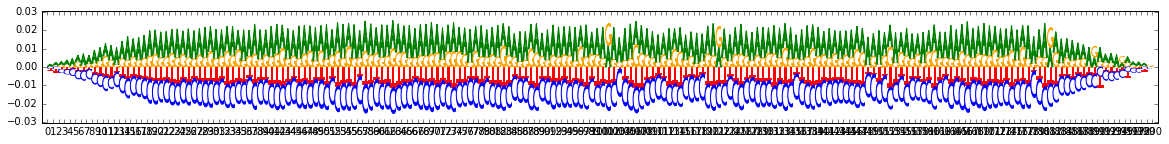

In [191]:
from keras import backend as K
f = K.function([inp], [grad_layer1])
import numpy as np
idx=10
grads, = f([train_X[0:idx]])

from deeplift.visualization import viz_sequence 
%matplotlib inline

viz_sequence.plot_weights(grads[2]-np.mean(grads[2],axis=1)[:,None])
